# Скачивание данных

Скачиваем данные, они лежат у меня на гугл диске - так как файл большой, то загрузка займет где-то 3 минуты

In [ ]:
!pip install gdown
!gdown --fuzzy --id 1ojCij10rN3g9zZzaJEqU1y1JsGkgohpw

/usr/local/lib/python3.11/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=1ojCij10rN3g9zZzaJEqU1y1JsGkgohpw
From (redirected): https://drive.google.com/uc?id=1ojCij10rN3g9zZzaJEqU1y1JsGkgohpw&confirm=t&uuid=79129d93-9682-4db0-9dde-ef9a02736479
To: /content/ml-intensive-yandex-academy-spring-2025.zip
100% 8.48G/8.48G [02:08<00:00, 65.8MB/s]


Теперь разорхивируем наши данные, они появятся в папке human_poses_data

In [ ]:
!unzip ml-intensive-yandex-academy-spring-2025.zip

Выходные данные были обрезаны до нескольких последних строк (5000).
  inflating: human_poses_data/img_train/3413.jpg  
  inflating: human_poses_data/img_train/3414.jpg  
  inflating: human_poses_data/img_train/3417.jpg  
  inflating: human_poses_data/img_train/3418.jpg  
  inflating: human_poses_data/img_train/3420.jpg  
  inflating: human_poses_data/img_train/3421.jpg  
  inflating: human_poses_data/img_train/3422.jpg  
  inflating: human_poses_data/img_train/3423.jpg  
  inflating: human_poses_data/img_train/3424.jpg  
  inflating: human_poses_data/img_train/3425.jpg  
  inflating: human_poses_data/img_train/3427.jpg  
  inflating: human_poses_data/img_train/3428.jpg  
  inflating: human_poses_data/img_train/3429.jpg  
  inflating: human_poses_data/img_train/3431.jpg  
  inflating: human_poses_data/img_train/3432.jpg  
  inflating: human_poses_data/img_train/3434.jpg  
  inflating: human_poses_data/img_train/3435.jpg  
  inflating: human_poses_data/img_train/3437.jpg  
  inflating: h

# Импорт библиотек

In [ ]:
import pandas as pd
import numpy as np
import os
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader, random_split, ConcatDataset
from PIL import Image
import torch
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import albumentations as A
from albumentations.pytorch import ToTensorV2
import cv2
import random

# Обработка данных

Создадим кастомный датасет для работы с изображениями и стандартную обработку изображений

In [ ]:
class CustomImageDataset(Dataset):
    def __init__(self, img_dir, transform=None, train=True, annotations_file=''):
        if train:
            self.img_labels = pd.read_csv(annotations_file)
        self.img_names = os.listdir(img_dir)
        self.img_dir = img_dir
        self.transform = transform
        self.train = train

    def __len__(self):
        return len(self.img_names)

    def __getitem__(self, idx):
        if self.train:
            img_path = os.path.join(self.img_dir, str(self.img_labels.iloc[idx, 0])+'.jpg')  # первый столбец - имя файла
        else:
            img_path = os.path.join(self.img_dir, self.img_names[idx])
        image = Image.open(img_path).convert('RGB')

        if self.transform:
            image = self.transform(image)
        if not self.train:
            return image, int(self.img_names[idx].replace('.jpg', "")) # изображение и метка
        label = self.img_labels.iloc[idx, 1]  # второй столбец - метка
        return image, label

# Пока стандартная обработка, затем будет добавлена специфическая
data_transform = transforms.Compose([
    transforms.Resize((227, 227)),  # измените размер по необходимости
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # стандартные значения для ImageNet
])

# Создаем датасеты
train_dataset = CustomImageDataset(
    annotations_file='./human_poses_data/train_answers.csv',
    img_dir='./human_poses_data/img_train',
    transform=data_transform
)

test_dataset = CustomImageDataset(
    img_dir='./human_poses_data/img_test',
    train=False,
    transform=data_transform
)

Теперь посмотрим на первые 5 фотографий в train

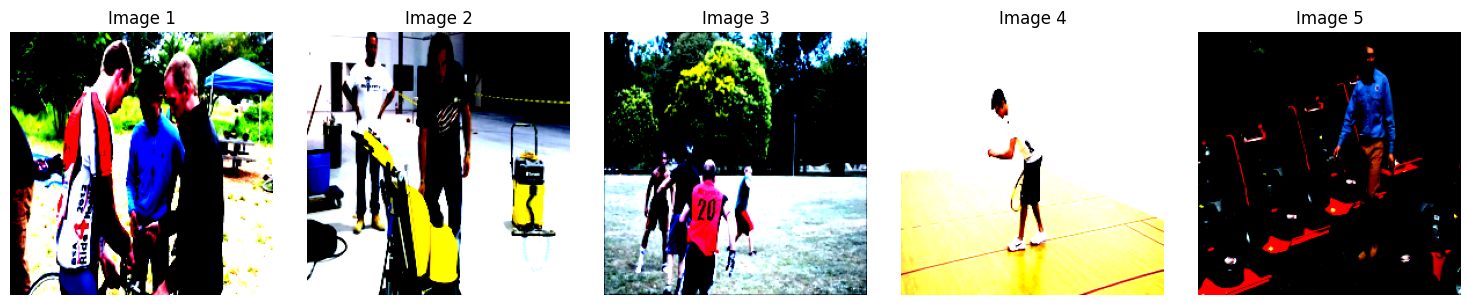

In [ ]:
n = 5
fig, axes = plt.subplots(1, n, figsize=(15, 3))
for i in range(n):
    img = train_dataset[i][0].numpy().transpose(1, 2, 0)  # меняем оси (C, H, W) → (H, W, C)
    axes[i].imshow(img)
    axes[i].axis('off')  # убираем оси
    axes[i].set_title(f"Image {i+1}")
plt.tight_layout()  # избегаем наложений
plt.show()

Разделим на тренировочный и валидационный датасеты

In [ ]:
# train_size = int(0.8 * len(train_dataset))  # 80%
# val_size = len(train_dataset) - train_size  # 20%
# train_subset, val_subset = random_split(
#     train_dataset,
#     [train_size, val_size],
#     generator=torch.Generator().manual_seed(42)  # для воспроизводимости
# )

Теперь обернем наши датасеты в даталоадеры для дальнейшей работы с нейросетями

In [ ]:
# batch_size = 64

# train_loader = DataLoader(
#     train_subset,
#     batch_size=batch_size,
#     shuffle=True,
#     num_workers=2
# )

# val_loader = DataLoader(
#     val_subset,
#     batch_size=batch_size,
#     shuffle=False,
#     num_workers=2
# )

# test_loader = DataLoader(
#     test_dataset,
#     batch_size=batch_size,
#     shuffle=False,  # важно не перемешивать тестовые данные!
#     num_workers=2
# )

Итог: Для тех, кто тестирует модели, может на вход принимать описанные выше лоадеры, таким образом каждой сети на вход будут поступать одинаковое кол-во данных.

Сейчас это нормализованные изображения размера 227х227

# Анализ данных

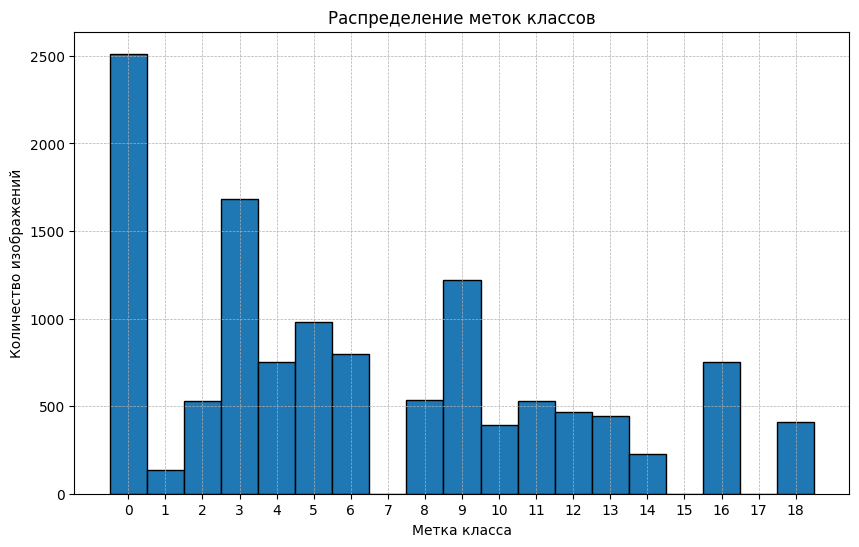

In [ ]:
labels = [label for _, label in train_dataset]

# Создание гистограммы
plt.figure(figsize=(10, 6))
bins = np.arange(min(labels), max(labels) + 2) - 0.5
plt.hist(labels, bins=bins, edgecolor='black', align='mid')

# Настройка графика
plt.title('Распределение меток классов')
plt.xlabel('Метка класса')
plt.ylabel('Количество изображений')
plt.xticks(np.arange(min(labels), max(labels) + 1, 1))  # Метки по целым числам
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

# Отображение графика
plt.show()

Из гистограммы видно, что изображений 0 класса слишком много по сравнению с остальными, тогда как 7, 15 и 17 вообще нет

In [ ]:
# Метод для добавления Гауссова шума к изображению
def add_noise(images, noise_factor=0.2):
    noise = torch.randn_like(images) * noise_factor
    noisy_images = images + noise
    noisy_images = torch.clamp(noisy_images, 0., 1.)  # Ограничиваем значения в диапазоне [0, 1]
    return noisy_images

In [ ]:
# Получаем изображения и метки из оригинального датасета
class_1_indices = [i for i, label in enumerate(labels) if label == 1]
class_14_indices = [i for i, label in enumerate(labels) if label == 14]

class_1_images = torch.stack([train_dataset[i][0] for i in class_1_indices])
class_14_images = torch.stack([train_dataset[i][0] for i in class_14_indices])

class_1_labels = [train_dataset[i][1] for i in class_1_indices]
class_14_labels = [train_dataset[i][1] for i in class_14_indices]

noisy_class_1_images = add_noise(class_1_images, noise_factor=0.2)
noisy_class_14_images = add_noise(class_14_images, noise_factor=0.2)

# Создаем списки для нового датасета с шумовыми изображениями
noisy_class_1_data = list(zip(noisy_class_1_images, class_1_labels))
noisy_class_14_data = list(zip(noisy_class_14_images, class_14_labels))

Альтернативная аугментация

In [ ]:
weak_aug_transform = transforms.Compose([
    transforms.Resize((227, 227)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=15),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

strong_aug_transform = transforms.Compose([
    transforms.Resize((227, 227)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.3),
    transforms.RandomRotation(degrees=30),
    transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5, hue=0.1),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1), scale=(0.9, 1.1)),
    transforms.GaussianBlur(kernel_size=3, sigma=(0.1, 2.0)),
    transforms.RandomPerspective(distortion_scale=0.3, p=0.5),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

Создадим  датасет с аугментацией - для этого объединим три датасета

In [ ]:
aug_dataset_weak = CustomImageDataset(
    annotations_file='./human_poses_data/train_answers.csv',
    img_dir='./human_poses_data/img_train',
    transform=weak_aug_transform
)

aug_dataset_strong = CustomImageDataset(
    annotations_file='./human_poses_data/train_answers.csv',
    img_dir='./human_poses_data/img_train',
    transform=strong_aug_transform
)

# Объединяем все датасеты
train_dataset = ConcatDataset([train_dataset, noisy_class_1_data, noisy_class_14_data, aug_dataset_weak, aug_dataset_strong])

In [ ]:
# Разделяем на train и val
train_size = int(0.8 * len(train_dataset))  # 80%
val_size = len(train_dataset) - train_size  # 20%
train_subset, val_subset = random_split(
    train_dataset,
    [train_size, val_size],
    generator=torch.Generator().manual_seed(42)  # для воспроизводимости
)

In [ ]:
batch_size = 64

train_loader = DataLoader(
    train_subset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=2
)

val_loader = DataLoader(
    val_subset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=2
)

test_loader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=False,  # важно не перемешивать тестовые данные!
    num_workers=2
)

Выведем полученные изображения

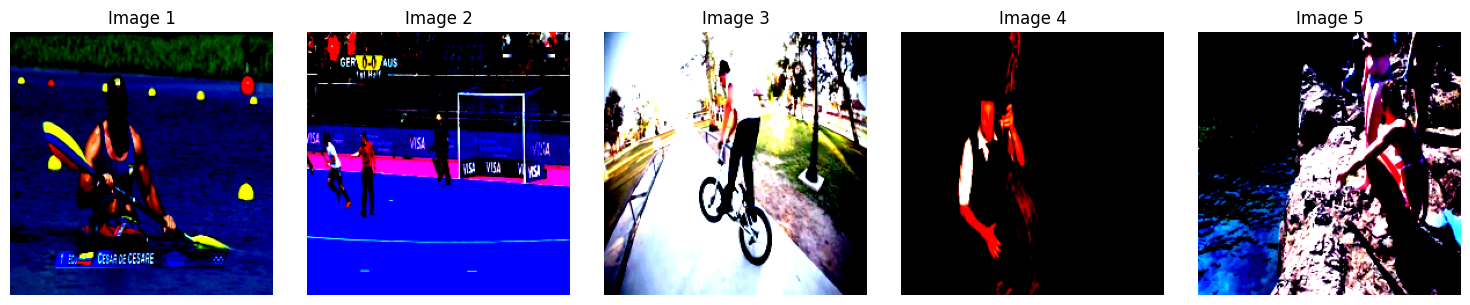

In [ ]:
n = 5
fig, axes = plt.subplots(1, n, figsize=(15, 3))
for i in range(n):
    img = train_dataset[15+i][0].numpy().transpose(1, 2, 0)  # меняем оси (C, H, W) → (H, W, C)
    axes[i].imshow(img)
    axes[i].axis('off')  # убираем оси
    axes[i].set_title(f"Image {i+1}")
plt.tight_layout()  # избегаем наложений
plt.show()

Добавим реализацию смешения данных

In [ ]:
def mixup_data(x, y, alpha=0.4):
    """
    x - batch of images (Tensor)
    y - batch of labels (Tensor)
    """
    if alpha > 0:
        lam = np.random.beta(alpha, alpha)
    else:
        lam = 1

    batch_size = x.size(0)
    index = torch.randperm(batch_size).to(x.device)

    mixed_x = lam * x + (1 - lam) * x[index, :]
    y_a, y_b = y, y[index]
    return mixed_x, y_a, y_b, lam

# Аугментация данных

Опишем трансформацию для изображений

In [ ]:
# aug_transform = transforms.Compose([
#     transforms.Resize((227, 227)),
#     transforms.RandomHorizontalFlip(p=0.5),
#     transforms.RandomVerticalFlip(p=0.2),
#     transforms.RandomRotation(degrees=15),
#     transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
#     transforms.RandomAffine(degrees=0, translate=(0.1, 0.1), scale=(0.9, 1.1)),
#     transforms.GaussianBlur(kernel_size=3, sigma=(0.1, 2.0)),
#     transforms.ToTensor(),
#     transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # ImageNet stats
# ])

Создадим датасет с аугментацией - для этого объединим два датасета

In [ ]:
# aug_dataset = CustomImageDataset(
#     annotations_file='./human_poses_data/train_answers.csv',
#     img_dir='./human_poses_data/img_train',
#     transform=aug_transform
# )
# train_dataset = ConcatDataset([aug_dataset, train_dataset])

In [ ]:
# train_size = int(0.8 * len(train_dataset))  # 80%
# val_size = len(train_dataset) - train_size  # 20%
# train_subset, val_subset = random_split(
#     train_dataset,
#     [train_size, val_size],
#     generator=torch.Generator().manual_seed(42)  # для воспроизводимости
# )

In [ ]:
# batch_size = 64

# train_loader = DataLoader(
#     train_subset,
#     batch_size=batch_size,
#     shuffle=True,
#     num_workers=2
# )

# val_loader = DataLoader(
#     val_subset,
#     batch_size=batch_size,
#     shuffle=False,
#     num_workers=2
# )

# test_loader = DataLoader(
#     test_dataset,
#     batch_size=batch_size,
#     shuffle=False,  # важно не перемешивать тестовые данные!
#     num_workers=2
# )

Выведем полученные изображения

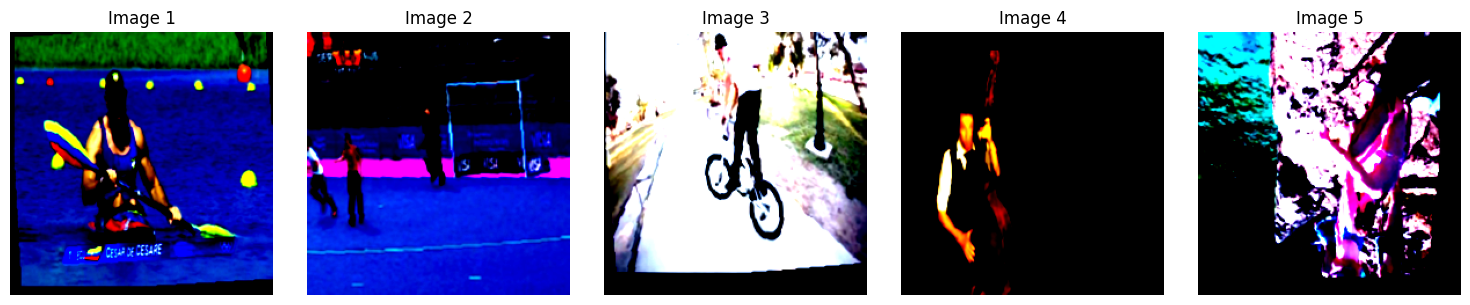

In [ ]:
# n = 5
# fig, axes = plt.subplots(1, n, figsize=(15, 3))
# for i in range(n):
#     img = train_dataset[15+i][0].numpy().transpose(1, 2, 0)  # меняем оси (C, H, W) → (H, W, C)
#     axes[i].imshow(img)
#     axes[i].axis('off')  # убираем оси
#     axes[i].set_title(f"Image {i+1}")
# plt.tight_layout()  # избегаем наложений
# plt.show()

# Архитектуры нейронных сетей и эксперименты

## Реализация AlexNet

Простой пример архитектуры нейронной сети.

На вход подается изображение 3x224x224

In [ ]:
class BigAlexNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 96, kernel_size=11, stride=4) #96х55х55
        self.maxpool1 = nn.MaxPool2d(kernel_size=3, stride=2) #96x27x27
        self.conv2 = nn.Conv2d(96, 256, kernel_size=5, padding=2)
        self.maxpool2 = nn.MaxPool2d(kernel_size=3, stride=2)
        self.conv3 = nn.Conv2d(256, 384, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(384, 384, kernel_size=3, padding=1)
        self.conv5 = nn.Conv2d(384, 256, kernel_size=3, padding=1)
        self.maxpool3 = nn.MaxPool2d(kernel_size=3, stride=2)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(in_features=9216, out_features=4096)
        self.fc2 = nn.Linear(in_features=4096, out_features=4096)
        self.fc3 = nn.Linear(in_features=4096, out_features=20)

    def forward(self, x):
        x = self.maxpool1(self.conv1(x))
        x = self.maxpool2(self.conv2(x))
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.maxpool3(self.conv5(x))
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)
        return x

Описание модели

In [ ]:
BigAlexNet()

BigAlexNet(
  (conv1): Conv2d(3, 96, kernel_size=(11, 11), stride=(4, 4))
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(96, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (maxpool2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(256, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(384, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv5): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (maxpool3): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=9216, out_features=4096, bias=True)
  (fc2): Linear(in_features=4096, out_features=4096, bias=True)
  (fc3): Linear(in_features=4096, out_features=20, bias=True)
)

Опишем обучение модели

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = BigAlexNet().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)


def mixup_criterion(criterion, pred, y_a, y_b, lam):
    return lam * criterion(pred, y_a) + (1 - lam) * criterion(pred, y_b)

In [ ]:
from sklearn.metrics import f1_score

num_epochs = 10
def train(num_epochs, criterion, optimizer, model, train_loader, val_loader, use_mixup=True, alpha=0.4):
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        all_train_preds = []
        all_train_targets = []

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            if use_mixup:
                inputs, targets_a, targets_b, lam = mixup_data(images, labels, alpha)
                optimizer.zero_grad()
                outputs = model(inputs)
                loss = mixup_criterion(criterion, outputs, targets_a, targets_b, lam)

                # Для mixup сохраняем предсказания и метки с учетом весов
                _, predicted = torch.max(outputs.data, 1)
                all_train_preds.extend(predicted.cpu().numpy())
                all_train_preds.extend(predicted.cpu().numpy())  # Дублируем предсказания
                all_train_targets.extend(targets_a.cpu().numpy())
                all_train_targets.extend(targets_b.cpu().numpy())
            else:
                optimizer.zero_grad()
                outputs = model(images)
                loss = criterion(outputs, labels)

                _, predicted = torch.max(outputs.data, 1)
                all_train_preds.extend(predicted.cpu().numpy())
                all_train_targets.extend(labels.cpu().numpy())

            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        train_loss /= len(train_loader)
        train_f1 = f1_score(all_train_targets, all_train_preds, average='micro')

        model.eval()
        val_loss = 0.0
        all_val_preds = []
        all_val_targets = []
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)

                val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                all_val_preds.extend(predicted.cpu().numpy())
                all_val_targets.extend(labels.cpu().numpy())

            val_loss /= len(val_loader)
            val_f1 = f1_score(all_val_targets, all_val_preds, average='micro')

        print(f"Epoch {epoch+1}/{num_epochs}")
        print(f"Train Loss: {train_loss:.4f}, Train F1: {train_f1:.4f}")
        print(f"Val Loss: {val_loss:.4f}, Val F1: {val_f1:.4f}")

    return model

Обучим модель

In [ ]:
model = train(num_epochs, criterion, optimizer, model, train_loader, val_loader, use_mixup=True, alpha=0.4)

Теперь сохраним ее в файл

In [ ]:
torch.save(model, 'model_full_bigAlexNet.pth')

In [ ]:
torch.save(model.state_dict(), 'model_weights.pth')

## Упрощённый вариант HoG

Здесь описана функция для подсчета градиентов - просто применили два фильтра Собеля

In [ ]:
def compute_sobel_gradients_two_loops(image):
    # Get image dimensions
    height, width = image.shape

    # Initialize output gradients
    gradient_x = np.zeros_like(image, dtype=np.float64)
    gradient_y = np.zeros_like(image, dtype=np.float64)

    # Pad the image with zeros to handle borders
    padded_image = np.pad(image, ((1, 1), (1, 1)), mode='constant', constant_values=0)

    # Define the Sobel kernels for X and Y gradients
    sobel_y = np.array([
        [-1, -2, -1],
        [0, 0, 0],
        [1, 2, 1]
    ])
    sobel_x = np.array([
        [-1, 0, 1],
        [-2, 0, 2],
        [-1, 0, 1]
    ])

    # Apply Sobel filter for X and Y gradients using convolution
    for i in range(1, height + 1):
        for j in range(1, width + 1):
            tmp = padded_image[i-1:i+2, j-1:j+2]
            gradient_x[i-1, j-1] = np.sum(tmp * sobel_x)
            gradient_y[i-1, j-1] = np.sum(tmp * sobel_y)
    return gradient_x, gradient_y

Посмотрим какие элементы выделяют фильтры

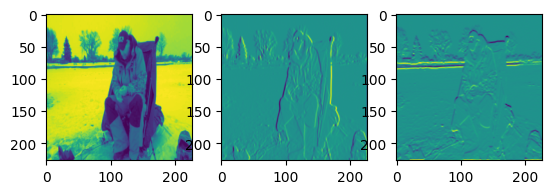

In [ ]:
image = random.choice(train_subset)[0][0].numpy()
gradients_two_loops = compute_sobel_gradients_two_loops(image)

plt.subplot(1, 3, 1)
plt.imshow(image)
plt.subplot(1, 3, 2)
plt.imshow(gradients_two_loops[0])
plt.subplot(1, 3, 3)
plt.imshow(gradients_two_loops[1])

Теперь переведем все в полярные координаты - таким образом у нас будет матрица магнитуд и направлений градиента

In [ ]:
def compute_gradient_magnitude(sobel_x, sobel_y):
    '''
    Compute the magnitude of the gradient given the x and y gradients.

    Inputs:
        sobel_x: numpy array of the x gradient.
        sobel_y: numpy array of the y gradient.

    Returns:
        magnitude: numpy array of the same shape as the input [0] with the magnitude of the gradient.
    '''
    magnitude = (sobel_x ** 2 + sobel_y ** 2) ** 0.5
    return magnitude


def compute_gradient_direction(sobel_x, sobel_y):
    '''
    Compute the direction of the gradient given the x and y gradients. Angle must be in degrees in the range (-180; 180].
    Use arctan2 function to compute the angle.

    Inputs:
        sobel_x: numpy array of the x gradient.
        sobel_y: numpy array of the y gradient.

    Returns:
        gradient_direction: numpy array of the same shape as the input [0] with the direction of the gradient.
    '''
    direction = np.arctan2(sobel_y, sobel_x)
    direction = np.degrees(direction)
    return direction

Также посмотрим на наши преобразования

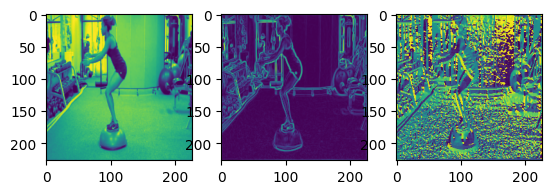

In [ ]:
image = random.choice(train_subset)[0][0].numpy()
magnitudes = compute_gradient_magnitude(*compute_sobel_gradients_two_loops(image))
directions = compute_gradient_direction(*compute_sobel_gradients_two_loops(image))

plt.subplot(1, 3, 1)
plt.imshow(image)
plt.subplot(1, 3, 2)
plt.imshow(magnitudes)
plt.subplot(1, 3, 3)
plt.imshow(directions)

Теперь пройдемся по кусочкам изображений и переведем их в вектор-гистограмму

In [ ]:
cell_size = 7
def compute_hog(image, pixels_per_cell=(cell_size, cell_size), bins=30):
    # 1. Convert the image to grayscale if it's not already (assuming the image is in RGB or BGR)
    if len(image.shape) == 3:
        image = np.mean(image, axis=2)  # Simple averaging to convert to grayscale

    # 2. Compute gradients with Sobel filter
    gradient_x, gradient_y = compute_sobel_gradients_two_loops(image) # YOUR CODE HERE

    # 3. Compute gradient magnitude and direction
    magnitude = compute_gradient_magnitude(gradient_x, gradient_y) # YOUR CODE HERE
    direction = compute_gradient_direction(gradient_x, gradient_y) # YOUR CODE HERE

    # 4. Create histograms of gradient directions for each cell
    cell_height, cell_width = pixels_per_cell
    n_cells_x = image.shape[1] // cell_width
    n_cells_y = image.shape[0] // cell_height

    histograms = np.zeros((n_cells_y, n_cells_x, bins))

    for i in range(n_cells_y):
        for j in range(n_cells_x):
            tmp_magnitude = magnitude[i * cell_height: (i + 1) * cell_height, j * cell_width: (j + 1) * cell_width]
            tmp_direction = direction[i * cell_height: (i + 1) * cell_height, j * cell_width: (j + 1) * cell_width]
            if np.all(tmp_magnitude == 0):
                histograms[i][j] = np.zeros(bins)
            else:
                histograms[i][j], _ = np.histogram(
                    tmp_direction,
                    bins=bins,
                    weights=tmp_magnitude,
                    range=(-180, 180),
                    density=False
                )
                histograms[i][j] /= np.sum(histograms[i][j])
    return histograms

Визуализируем наши разбиения и отобразим часть гистограмм

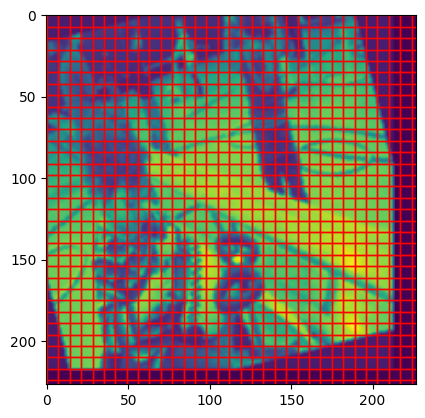

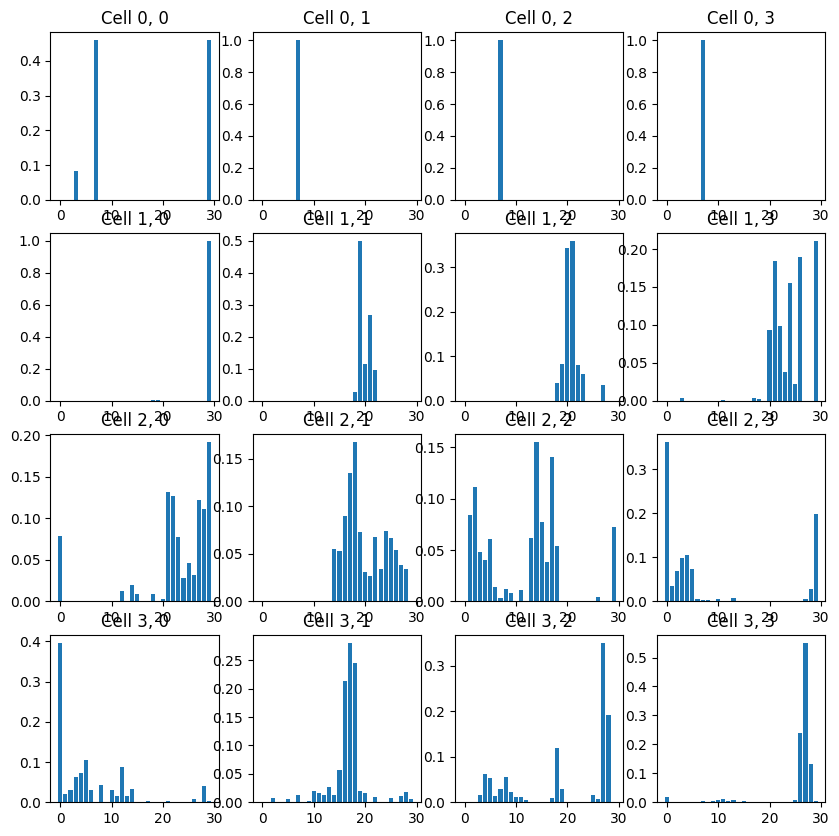

In [ ]:
#plot all the histograms for (3, 3) cells:
image = random.choice(train_subset)[0][0].numpy()
hog = compute_hog(image)

# draw cells on the image
plt.imshow(image)
for i in range((image.shape[0] + cell_size - 1) // cell_size):
    for j in range((image.shape[1] + cell_size - 1) // cell_size):
        plt.gca().add_patch(plt.Rectangle((j * cell_size, i * cell_size), cell_size, cell_size, fill=False, edgecolor='red', linewidth=1))
plt.show()


plt.figure(figsize=(10, 10))
for i in range(4):
    for j in range(4):
        plt.subplot(4, 4, i * 4 + j + 1)
        plt.bar(range(len(hog[i, j])), hog[i, j])
        plt.title(f"Cell {i}, {j}")
plt.show()

Нейронная сеть для обработки hog

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class HOGNet(nn.Module):
    def __init__(self, input_shape, num_classes):
        """
        Args:
            input_shape: (n_blocks_y, n_blocks_x, n_bins) - форма HOG-признаков
            num_classes: количество классов классификации
        """
        super(HOGNet, self).__init__()

        n_blocks_y, n_blocks_x, n_bins = input_shape

        # Улучшенная архитектура для работы с HOG
        self.features = nn.Sequential(
            nn.Conv2d(n_bins, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            # nn.MaxPool2d(2),

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),

            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True)
        )

        # Динамический расчет размера после сверток
        with torch.no_grad():
            dummy_input = torch.zeros(1, n_bins, n_blocks_y, n_blocks_x)
            dummy_output = self.features(dummy_input)
            conv_output_size = dummy_output.view(-1).shape[0]

        self.classifier = nn.Sequential(
            nn.Linear(conv_output_size, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        # Переводим из формата (..., n_blocks_y, n_blocks_x, n_bins)
        # в формат (..., n_bins, n_blocks_y, n_blocks_x)
        if x.dim() == 4:
            x = x.permute(0, 3, 1, 2)
        elif x.dim() == 3:
            x = x.permute(2, 0, 1).unsqueeze(0)

        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

In [ ]:
# class HybridNet(nn.Module):
#     def __init__(self, hog_shape, num_classes):
#         super().__init__()

#         # Ветка для HOG
#         self.hog_branch = nn.Sequential(
#             nn.Conv2d(hog_shape[-1], 32, 3),
#             nn.ReLU(),
#             nn.MaxPool2d(2)
#         )

#         # Ветка для сырых пикселей
#         self.pixel_branch = nn.Sequential(
#             nn.Conv2d(3, 32, 3),
#             nn.ReLU(),
#             nn.MaxPool2d(2)
#         )

#         # Объединяющий классификатор
#         self.classifier = nn.Sequential(
#             nn.Linear(64*54*54, 256),  # Примерный размер
#             nn.ReLU(),
#             nn.Linear(256, num_classes)
#         )

#     def forward(self, hog_input, pixel_input):
#         hog_out = self.hog_branch(hog_input.permute(0,3,1,2))
#         pixel_out = self.pixel_branch(pixel_input)

#         combined = torch.cat([hog_out, pixel_out], dim=1)
#         return self.classifier(combined.flatten(1))

In [ ]:
from torchvision import transforms
from skimage.feature import hog
import numpy as np

class HOGTransform:
    def __init__(self, pixels_per_cell=(7,7), cells_per_block=(2,2), bins=9):
        self.pixels_per_cell = pixels_per_cell
        self.cells_per_block = cells_per_block
        self.bins = bins

    def __call__(self, img):
        # Конвертируем в numpy если это тензор
        if isinstance(img, torch.Tensor):
            img = img.permute(1, 2, 0).numpy()
            if img.max() <= 1.0:
                img = (img * 255).astype(np.uint8)
            else:
                img = img.astype(np.uint8)

        # Вычисляем HOG-признаки
        hog_features = hog(
            img,
            orientations=self.bins,
            pixels_per_cell=self.pixels_per_cell,
            cells_per_block=self.cells_per_block,
            channel_axis=-1 if img.ndim == 3 else None,
            feature_vector=False
        )

        # Нормализация L2 внутри блоков
        eps = 1e-7
        hog_features = hog_features / (np.linalg.norm(hog_features, axis=-1, keepdims=True) + eps)

        # Усреднение по блокам
        hog_features = hog_features.mean(axis=(2,3))  # (n_blocks_y, n_blocks_x, bins)

        # Глобальная нормализация
        hog_features = hog_features / (np.linalg.norm(hog_features) + eps)

        # Конвертация в тензор [C, H, W]
        return torch.from_numpy(hog_features).permute(2, 0, 1).float()

# Пример параметров HOG
hog_params = {
    'pixels_per_cell': (7, 7),
    'cells_per_block': (2, 2),
    'bins': 9
}

# Полный пайплайн преобразований
hog_transform = transforms.Compose([
    transforms.Resize((227, 227)),
    transforms.ToTensor(),
    HOGTransform(**hog_params)
])

In [ ]:
num_epochs = 20

hog_train_dataset = CustomImageDataset(
    annotations_file='./human_poses_data/train_answers.csv',
    img_dir='./human_poses_data/img_train',
    transform=hog_transform
)

In [ ]:
# train_size = int(0.8 * len(hog_train_dataset))  # 80%
# val_size = len(hog_train_dataset) - train_size  # 20%
# train_subset, val_subset = random_split(
#     hog_train_dataset,
#     [train_size, val_size],
#     generator=torch.Generator().manual_seed(42)  # для воспроизводимости
# )

In [ ]:
train_subset[0][0].shape

torch.Size([9, 31, 31])

In [ ]:
# batch_size = 64

# train_loader = DataLoader(
#     train_subset,
#     batch_size=batch_size,
#     shuffle=True,
#     num_workers=2
# )

# val_loader = DataLoader(
#     val_subset,
#     batch_size=batch_size,
#     shuffle=False,
#     num_workers=2
# )

# test_loader = DataLoader(
#     test_dataset,
#     batch_size=batch_size,
#     shuffle=False,  # важно не перемешивать тестовые данные!
#     num_workers=2
# )

In [ ]:
input_shape

torch.Size([9, 31, 31])

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# block_size = hog_params['cells_per_block'][0] * hog_params['pixels_per_cell'][0]
# n_cells = (train_subset[0][0].shape[0] - block_size +
#              hog_params['pixels_per_cell'][0]) // hog_params['pixels_per_cell'][0]
input_shape = train_subset[0][0].shape
#  (n_cells, n_cells, hog_params['bins'])  # Пример формы после HOG (зависит от размера изображения)
num_classes = 20

model = HOGNet(input_shape, num_classes).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [ ]:
model = train(num_epochs, criterion, optimizer, model, train_loader, val_loader)

Epoch 1, Loss: 2.4533, Accuracy: 0.20735650767987066
Epoch 2, Loss: 2.3852, Accuracy: 0.22352465642683914


KeyboardInterrupt: 

## SENet

Алгоритм обучения нейросети, построенной наподобие SENet

Скачиваем веса модели из Google Drive (12 эпох)

In [ ]:
!pip install gdown
!mkdir -p checkpoints  # Создаем папку checkpoints, если ее нет

# Загружаем файл по ID
!gdown --id 1XnKHAE1y54RKXghfCj1vXl7sT-iUCvG8 -O checkpoints/best_model.pth

/usr/local/lib/python3.11/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=1XnKHAE1y54RKXghfCj1vXl7sT-iUCvG8
From (redirected): https://drive.google.com/uc?id=1XnKHAE1y54RKXghfCj1vXl7sT-iUCvG8&confirm=t&uuid=65eb96bb-d422-4f28-9c5c-0472274daf7b
To: /content/checkpoints/best_model.pth
100% 135M/135M [00:03<00:00, 38.1MB/s]


Скачиваем веса модели из Google Drive (15 эпох)

In [ ]:
!pip install gdown
!mkdir -p checkpoints  # Создаем папку checkpoints, если ее нет
# Загружаем файл по ссылке
!gdown --id 1R_RhZcJ0QWUCIo11_dpSYWCui5k1Xrwr -O checkpoints/best_model.pth

/usr/local/lib/python3.11/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=1R_RhZcJ0QWUCIo11_dpSYWCui5k1Xrwr
From (redirected): https://drive.google.com/uc?id=1R_RhZcJ0QWUCIo11_dpSYWCui5k1Xrwr&confirm=t&uuid=12652a7f-7da7-4e1f-bed1-51a50c2bf3de
To: /content/checkpoints/best_model.pth
100% 135M/135M [00:01<00:00, 79.3MB/s]


Скачиваем веса модели из Google Drive (20 эпох)

In [ ]:
!pip install gdown
!mkdir -p checkpoints  # Создаем папку checkpoints, если ее нет

# Загружаем файл по ссылке
!gdown --id 12I3lEzM7atziiSMsK40xGWYIO8XcGq6B -O checkpoints/best_model.pth

/usr/local/lib/python3.11/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=12I3lEzM7atziiSMsK40xGWYIO8XcGq6B
From (redirected): https://drive.google.com/uc?id=12I3lEzM7atziiSMsK40xGWYIO8XcGq6B&confirm=t&uuid=50a59f84-2633-42c4-b2fd-ff401cb4fe53
To: /content/checkpoints/best_model.pth
100% 135M/135M [00:01<00:00, 70.7MB/s]


Подключаем библтотеки

In [ ]:
import os
import math
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import ImageFolder
from tqdm import tqdm
from sklearn.metrics import f1_score

Архитектура нейросети

In [ ]:
class SEBlock(nn.Module):
    # Блок Squeeze-and-Excitation
    def __init__(self, in_channels, reduction=16):
        super().__init__()
        self.pool = nn.AdaptiveAvgPool2d(1)
        # Первый полносвязный слой (реализованный как свертка 1x1)
        self.fc1  = nn.Conv2d(in_channels, in_channels // reduction, 1, bias=True)
        self.act  = nn.ReLU(inplace=True)
        # Второй полносвязный слой - восстанавливает размерность
        self.fc2  = nn.Conv2d(in_channels // reduction, in_channels, 1, bias=True)
        self.sig  = nn.Sigmoid()

    def forward(self, x):
        # Получаем веса для каналов
        w = self.pool(x)
        w = self.fc1(w)
        w = self.act(w)
        w = self.fc2(w)
        w = self.sig(w)
        # Применяем веса к входным данным
        return x * w


class SEBasicBlock(nn.Module):
    # Базовый блок ResNet с SE-блоком и skip-connection
    expansion = 1
    def __init__(self, in_channels, out_channels, stride=1, reduction=16, downsample=None):
        super().__init__()
        # Первая свертка блока
        self.conv1 = nn.Conv2d(in_channels, out_channels, 3, stride=stride, padding=1, bias=False)
        self.bn1   = nn.BatchNorm2d(out_channels)
        self.relu  = nn.ReLU(inplace=True)
        # Вторая свертка блока
        self.conv2 = nn.Conv2d(out_channels, out_channels, 3, stride=1, padding=1, bias=False)
        self.bn2   = nn.BatchNorm2d(out_channels)
        # SE-блок для перевзвешивания каналов
        self.se    = SEBlock(out_channels, reduction)
        # Downsample слой для согласования размерностей в skip-connection
        self.downsample = downsample

    def forward(self, x):
        identity = x  # Сохраняем вход для skip-connection

        # Прямой проход через основной блок
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out = self.se(out)  # Применяем SE-блок

        if self.downsample is not None:
            identity = self.downsample(x)

        # Skip-connection и активация
        out += identity
        out = self.relu(out)
        return out


class SENet(nn.Module):
    # Основной класс SENet с настраиваемой архитектурой
    def __init__(self, block, layers, num_classes=20, reduction=16):
        super().__init__()
        self.in_channels = 64
        # Начальные слои
        self.conv1 = nn.Conv2d(3, 64, 7, stride=2, padding=3, bias=False)
        self.bn1   = nn.BatchNorm2d(64)
        self.relu  = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(3, stride=2, padding=1)

        # Создание слоев сети
        self.layer1 = self._make_layer(block, 64,  layers[0], stride=1, reduction=reduction)
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2, reduction=reduction)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2, reduction=reduction)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2, reduction=reduction)

        # Финальные слои для классификации
        self.avgpool = nn.AdaptiveAvgPool2d(1)
        self.fc      = nn.Linear(512 * block.expansion, num_classes)

        # Инициализация весов
        self._init_weights()

    def _make_layer(self, block, out_channels, blocks, stride, reduction):
        # Создает слой из нескольких блоков с возможностью downsample
        downsample = None
        if stride != 1 or self.in_channels != out_channels * block.expansion:
            downsample = nn.Sequential(
                # Свертка 1x1 для изменения размерности
                nn.Conv2d(self.in_channels, out_channels * block.expansion, 1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels * block.expansion),
            )

        layers = []
        # Первый блок в слое может иметь downsample и изменять размерность
        layers.append(block(self.in_channels, out_channels, stride, reduction, downsample))
        self.in_channels = out_channels * block.expansion

        # Добавляем остальные блоки в слой
        for _ in range(1, blocks):
            layers.append(block(self.in_channels, out_channels, reduction=reduction))

        return nn.Sequential(*layers)  # Объединяем все блоки в Sequential

    def _init_weights(self):
        # Инициализация весов для разных типов слоев
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_uniform_(m.weight, a=math.sqrt(5))
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.ones_(m.weight)
                nn.init.zeros_(m.bias)
            elif isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                nn.init.zeros_(m.bias)

    def forward(self, x):
        # Прямой проход через всю сеть
        # Начальные слои
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        # Проход через все основные слои
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        # Финальные слои для классификации
        x = self.avgpool(x).flatten(1)
        x = self.fc(x)

        return x

Необходимые функции

In [ ]:
def train_epoch(model, loader, optimizer, criterion, device):
  # Одна эпоха обучения модели
    model.train()
    total_loss = 0.0
    for imgs, labels in tqdm(loader, desc= "Training", unit= "batch"):
        imgs, labels = imgs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(loader)


def validate(model, loader, criterion, device):
  # Валидация модели
    model.eval()
    total_loss = 0.0
    all_preds, all_labels = [], []
    with torch.no_grad():
        for imgs, labels in tqdm(loader, desc= "Validation", unit= "batch"):
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs)
            total_loss += criterion(outputs, labels).item()
            preds = outputs.argmax(dim=1)
            all_preds.extend(preds.cpu().tolist())
            all_labels.extend(labels.cpu().tolist())
    val_f1 = f1_score(all_labels, all_preds, average= "weighted")
    return total_loss / len(loader), val_f1

def load_checkpoint(path, model, optimizer=None, scheduler=None):
  # Загрузка сохраненной модели и состояния обучения
    ckpt = torch.load(path, map_location='cpu')
    model.load_state_dict(ckpt['model_state'])
    if optimizer and 'optim_state' in ckpt:
        optimizer.load_state_dict(ckpt['optim_state'])
    if scheduler and 'sched_state' in ckpt:
        scheduler.load_state_dict(ckpt['sched_state'])
    start_epoch = ckpt['epoch'] + 1
    best_f1 = ckpt.get('best_f1', 0.0)
    print(f"Resumed from epoch {ckpt['epoch']}, best_f1={best_f1:.4f}")
    return start_epoch, best_f1

Запуск обучения

In [ ]:
if __name__ == '__main__':
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # Преобразования для входных изображений
    transform = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225]
        )
    ])

    # Инициализация модели, оптимизатора, планировщика и функции потерь
    model = SENet(SEBasicBlock, layers=[2,2,2,2], num_classes=20, reduction=16).to(device)
    optimizer = optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-5)
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=20)
    criterion = nn.CrossEntropyLoss()

    os.makedirs('checkpoints', exist_ok=True)
    resume_path = 'checkpoints/best_model.pth'
     # Попытка загрузить сохраненную модель
    if os.path.exists(resume_path):
        start_epoch, best_f1 = load_checkpoint(
            resume_path, model, optimizer, scheduler
        )
    else:
        start_epoch, best_f1 = 1, 0.0

    # Основной цикл обучения
    num_epochs = 25
    for epoch in range(start_epoch, num_epochs + 1):
        train_loss = train_epoch(model, train_loader, optimizer, criterion, device)
        scheduler.step()
        val_loss, val_f1 = validate(model, val_loader, criterion, device)

        print(f"Epoch {epoch}: "
              f"TrainLoss={train_loss:.4f}, "
              f"ValLoss={val_loss:.4f}, "
              f"ValF1={val_f1:.4f}")

        ckpt = {
            'epoch': epoch,
            'model_state': model.state_dict(),
            'optim_state': optimizer.state_dict(),
            'sched_state': scheduler.state_dict(),
            'best_f1': best_f1
        }
        torch.save(ckpt, f'checkpoints/epoch_{epoch}.pth')
        if val_f1 > best_f1:
            best_f1 = val_f1
            torch.save(ckpt, 'checkpoints/best_model.pth')


Resumed from epoch 15, best_f1=0.8456


Training:   2%|▏         | 14/619 [00:29<21:04,  2.09s/batch]


KeyboardInterrupt: 

### Архитектура ResNext

In [ ]:
# Базовый bottleneck-блок
class Bottleneck(nn.Module):
    expansion = 4  # выходной канал увеличивается в 4 раза

    def __init__(
        self,
        inplanes,                      # число входных каналов
        planes,                        # базовое число каналов (умножится на expansion)
        stride=1,
        downsample=None,
        groups=32,                   # число групп в group conv
        base_width=4,                # ширина одной группы
        dilation=1,
        norm_layer=None,
    ):
        super().__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d

        # Вычисляем ширину для group conv
        width = int(planes * (base_width / 64.0)) * groups

        # Первая 1x1 свёртка (сжимает каналы)
        self.conv1 = nn.Conv2d(inplanes, width, kernel_size=1, bias=False)
        self.bn1 = norm_layer(width)

        # Групповая 3x3 свёртка
        self.conv2 = nn.Conv2d(
            width, width, kernel_size=3, stride=stride,
            padding=dilation, groups=groups, bias=False, dilation=dilation
        )
        self.bn2 = norm_layer(width)

        # Последняя 1x1 свёртка (расширяет до `planes * expansion`)
        self.conv3 = nn.Conv2d(width, planes * self.expansion, kernel_size=1, bias=False)
        self.bn3 = norm_layer(planes * self.expansion)

        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample  # shortcut, если нужно изменить размерность
        self.stride = stride

    def forward(self, x):
        identity = x  # сохраняем для shortcut

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        # если размернооость не совпадает, применяем shortcut
        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity  # остаточное соединение
        out = self.relu(out)
        return out

In [ ]:
class ResNeXt(nn.Module):
    def __init__(
        self,
        block,
        layers,                  # список с количеством блоков в каждом из 4 этапов
        num_classes=20,
        zero_init_residual=False,
        groups=32,
        width_per_group=4,
        replace_stride_with_dilation=None,
        norm_layer=None,
    ):
        super().__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d

        self._norm_layer = norm_layer
        self.inplanes = 64                 # начальное число каналов после conv1
        self.dilation = 1

        if replace_stride_with_dilation is None:
            replace_stride_with_dilation = [False, False, False]

        if len(replace_stride_with_dilation) != 3:
            raise ValueError()

        self.groups = groups
        self.base_width = width_per_group

        # Первая свёртка 7x7 + BN + ReLU
        self.conv1 = nn.Conv2d(3, self.inplanes, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = norm_layer(self.inplanes)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        # Этапы из Bottleneck-блоков
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2,
                                       dilate=replace_stride_with_dilation[0])
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2,
                                       dilate=replace_stride_with_dilation[1])
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2,
                                       dilate=replace_stride_with_dilation[2])

        # Глобальный пуллинг + полносвязный слой
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)

        # Инициализация весов
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode="fan_out", nonlinearity="relu")
            elif isinstance(m, (nn.BatchNorm2d, nn.GroupNorm)):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

        # Инициализация последнего BN в блоке нулями (по умолчанию выключена)
        if zero_init_residual:
            for m in self.modules():
                if isinstance(m, Bottleneck):
                    nn.init.constant_(m.bn3.weight, 0)

    # Создание одного stage'а (повторяющейся последовательности блоков)
    def _make_layer(self, block, planes, blocks,
                    stride=1, dilate=False):
        norm_layer = self._norm_layer
        downsample = None
        previous_dilation = self.dilation

        if dilate:
            self.dilation *= stride
            stride = 1

        # Если требуется изменить размерность, создаём downsample путь
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                norm_layer(planes * block.expansion),
            )

        layers = []
        # Первый блок со stride/downsample
        layers.append(
            block(
                self.inplanes, planes, stride, downsample,
                self.groups, self.base_width, previous_dilation, norm_layer
            )
        )
        self.inplanes = planes * block.expansion

        # Остальные блоки
        for _ in range(1, blocks):
            layers.append(
                block(
                    self.inplanes, planes,
                    groups=self.groups,
                    base_width=self.base_width,
                    dilation=self.dilation,
                    norm_layer=norm_layer
                )
            )

        return nn.Sequential(*layers)


    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)

        return x

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ResNeXt(Bottleneck, [3, 4, 6, 3], groups=32, width_per_group=4).to(device) # классический resnext50_32x4d
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters())
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min')

In [ ]:
EPOCHS = 20

In [ ]:
def load_checkpoint(path, device):
    checkpoint = torch.load(path, map_location=device, weights_only=True)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
    epoch = checkpoint['epoch']
    train_loss_hist = checkpoint["train_loss_hist"]
    val_loss_hist = checkpoint['val_loss_hist']
    val_accuracy_hist = checkpoint['val_accuracy_hist']
    best_f1_score = checkpoint.get("best_f1_score", 0)
    return epoch, train_loss_hist, val_loss_hist, val_accuracy_hist, best_f1_score

In [ ]:
prev_epochs, train_loss_hist, val_loss_hist, val_accuracy_hist, best_f1_score = load_checkpoint("resnext50_32x4d_checkpoint.pth", device)

In [ ]:
def print_elapsed_time(func):
    def wrapper(*args, **kwargs):
        start = datetime.datetime.now()
        func(*args, **kwargs)
        finish = datetime.datetime.now()
        print(f"\nTotal time elapsed: {str(finish - start)}")
        return
    return wrapper

In [ ]:
@print_elapsed_time
def train(criterion, optimizer, model, train_loader, val_loader, scheduler=None, best_f1_score=0):
    for epoch in range(EPOCHS):
        print(f"-----------------< Epoch [{epoch+1}/{EPOCHS}] >-----------------\n")

        model.train()
        train_loss = 0
        for images, labels in tqdm(train_loader):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            train_loss += loss.item()
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        train_loss /= len(train_loader)
        train_loss_hist.append(train_loss)

        model.eval()
        with torch.no_grad():
            val_loss = 0.0
            all_predictions, all_labels = [], []
            total = 0
            correct = 0
            for images, labels in tqdm(val_loader):
                images, labels = images.to(device), labels.to(device)

                outputs = model(images)
                predicted = torch.argmax(outputs, dim=1)

                total += labels.cpu().numpy().shape[0]
                correct += (predicted == labels).sum().item()

                loss = criterion(outputs, labels)
                val_loss += loss.item()

                all_predictions.extend(predicted.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())

        val_loss /= len(val_loader)
        val_acc = correct / total
        val_f1_score = f1_score(all_labels, all_predictions, average="weighted")
        val_loss_hist.append(val_loss)
        val_accuracy_hist.append(val_acc)

        if val_f1_score > best_f1_score:
            best_f1_score = val_f1_score
            checkpoint = {
                'epoch': epoch + prev_epochs + 1,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'scheduler_state_dict': scheduler.state_dict(),
                'train_loss_hist' : train_loss_hist,
                'val_loss_hist' : val_loss_hist,
                'val_accuracy_hist' : val_accuracy_hist,
                'best_f1_score' : best_f1_score
            }
            torch.save(checkpoint, 'resnext50_32x4d_checkpoint.pth')

        if scheduler is not None:
            scheduler.step(val_loss)
            print(f"Current LR: {scheduler.get_last_lr()[0]}")

        print(f"Loss: {val_loss:.4f}")
        print(f"F1 score: {val_f1_score:.4f}")
        print(f"Accuracy: {val_acc:.4f}")

In [ ]:
train(criterion, optimizer, model, train_loader, val_loader, scheduler, best_f1_score)

# Ансамблирование

## Загрузка моделей

In [ ]:
senet = SENet(SEBasicBlock, layers=[2,2,2,2], num_classes=20, reduction=16).to(device)
resnext = ResNeXt(Bottleneck, [3, 4, 6, 3], groups=32, width_per_group=4).to(device)

In [ ]:
path_to_senet = "/kaggle/input/..."
path_to_resnext = "/kaggle/input/..."

In [ ]:
senet_checkpoint = torch.load(path_to_senet, map_location="cpu", weights_only=False)
senet.load_state_dict(senet_checkpoint["model_state"])

resnext_checkpoint = torch.load(path_to_resnext, map_location="cpu", weights_only=False)
resnext.load_state_dict(resnext_checkpoint["model_state_dict"])

## Soft voting

In [ ]:
# Пробуем просто усреднять вероятности

senet.eval()
resnext.eval()

all_predictions, all_labels = [], []

with torch.no_grad():
    for images, labels in tqdm(val_loader):
        images, labels = images.to(device), labels.to(device)

        probs_senet = torch.softmax(senet(images), dim=1)
        probs_resnext = torch.softmax(resnext(images), dim=1)

        final_probs = (probs_senet + probs_resnext) / 2
        predicted = torch.argmax(final_probs, dim=1)

        all_predictions.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

result = f1_score(all_labels, all_predictions, average="weighted")

print(f"Soft voting result: {result}")

## Weighted voting

In [ ]:
senet.eval()
resnext.eval()

all_predictions, all_labels = [], []

with torch.no_grad():
    for images, labels in tqdm(val_loader):
        images, labels = images.to(device), labels.to(device)

        probs_senet = torch.softmax(senet(images), dim=1)
        probs_resnext = torch.softmax(resnext(images), dim=1)

        final_probs = 0.4 * probs_senet + 0.6 * probs_resnext
        predicted = torch.argmax(final_probs, dim=1)

        all_predictions.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

result = f1_score(all_labels, all_predictions, average="weighted")

print(f"Weighted voting result: {result}")

## Создаём и обучаем метамодель

In [ ]:
def get_probs(model, loader, device):
    model.eval()
    all_probs = []
    all_labels = []
    with torch.no_grad():
        for images, labels in tqdm(loader):
            images, labels = images.to(device), labels.to(device)
            cur_probs = torch.softmax(model(images), dim=1)
            all_probs.extend(cur_probs.cpu().numpy().tolist())
            all_labels.extend(labels.cpu().numpy().tolist())

    return all_probs, all_labels

In [ ]:
senet_probs, meta_targets = get_probs(senet, val_loader, device)
resnext_probs, _ = get_probs(resnext, val_loader, device)

meta_features = []
for i in range(len(senet_probs)):
    meta_features.append(senet_probs[i] + resnext_probs[i])

In [ ]:
from sklearn.linear_model import LogisticRegression

# На входе модель имеет набор вероятностей, склеенный из выходов resnext и senet
# На выходе — метка класса

meta_model = LogisticRegression(max_iter=1000)
meta_model.fit(meta_features, meta_targets)

## Сохранение предсказаний метамодели

In [ ]:
senet.eval()
resnext.eval()

probs_senet, idxs = get_probs(senet, test_loader, device)
probs_resnext, _    = get_probs(resnext, test_loader, device)

In [ ]:
results_save_path = "/kaggle/working/predictions_meta_model.csv"

res = {'id':[], 'predict':[]}

test_features = []
for i in range(len(probs_senet)):
    test_features.append(probs_senet[i] + probs_resnext[i])

predicts = meta_model.predict(test_features)

res['id'] = idxs
res['predict'] = predicts

results = pd.DataFrame(res)

results.to_csv(results_save_path, index=False, sep=',')

# Отправка решения на kaggle

Соберем ответ для отправки на kaggle

In [ ]:
res = {'id':[], 'predict':[]}
for images, idxs in test_loader:
    images = images.to(device)
    outputs = model(images).detach().cpu().numpy()
    predicts = outputs.argmax(axis=1)
    res['id'].append(idxs)
    res['predict'].append(predicts)

In [ ]:
tmp = res['id']
tmp_list = [item.item() for sublist in tmp for item in sublist]
new_res = {'id':tmp_list, 'predict':[]}
tmp = res['predict']
tmp_list = [item.item() for sublist in tmp for item in sublist]
new_res['predict'] = tmp_list

In [ ]:
results = pd.DataFrame({
    'id': new_res['id'],  # Берем Id из исходного файла
    'target_feature': new_res['predict']
})
results.to_csv('test1.csv', index=False, sep=',')

In [ ]:
results.to_csv('predictions.csv', index=False)

Проверим, что все записалось верно

In [ ]:
df = pd.read_csv('predictions.csv')
df.head()

,Id,target_feature
0,5606,0
1,14094,12
2,8443,3
3,6681,3
4,12559,0
